###### Setting work path

In [1]:
import os
os.getcwd()
os.chdir(u'C:/Users/dongwan.kim/Desktop/da_work/4000_게임과 로그/T5')
os.getcwd()

'C:\\Users\\dongwan.kim\\Desktop\\da_work\\4000_게임과 로그\\T5'

###### Data preperation

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, roc_curve

df = pd.read_csv('20171212_T5_data003_Mobile_T5__log_stat_tracking.csv')
y = df.iloc[:, 0].values
X = df.drop(df.columns[0], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

class_labels = ['stay', 'churn']

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


###### How to handle imbalance of class

- https://beckernick.github.io/oversampling-modeling/

In [3]:
df.iloc[:, 0].value_counts()

0    61923
1     8762
Name: is_churn_8h, dtype: int64

###### applying SMOTE

In [4]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0, ratio=1.0)
X_train_sm, y_train_sm = sm.fit_sample(X_train_std, y_train)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


So data sets we have.
- (X_train, y_train), (X_test, y_test)
- (X_train_std, y_train), (X_test, y_test)
- (X_train_sm, y_train_sm), (X_test, y_test)

In [5]:
print('Before applying SMOTE - 0:', len([y for y in y_train if y==0]), '1:', sum(y_train))
print('After applying SMOTE  - 0:', len([y for y in y_train_sm if y==0]), '1:', sum(y_train_sm))

Before applying SMOTE - 0: 43347 1: 6132
After applying SMOTE  - 0: 43347 1: 43347


###### Performance matrics

In [6]:
from sklearn.metrics import confusion_matrix, recall_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import itertools
% matplotlib inline


class PerfMatrics():
    def __init__(self, y_actual, X, model, class_labels=None):
        self.y_actual = y_actual
        self.model = model
        self.X = X
        
        self.y_predict = self.model.predict(X)
        self.y_predict_proba = self.model.predict_proba(X)[:, 1]
        
        self.class_labels = class_labels
        self.conf_matrix = confusion_matrix(self.y_actual, self.y_predict)
        self.tn, self.fp, self.fn, self.tp = self.conf_matrix.ravel()

    def print_all_matrics(self):
        self._print_accuracy()
        self._print_recall()
        self._print_classification_report(self.y_actual, self.y_predict, self.class_labels)

        plt.rcParams["figure.figsize"] = (11,5)
        
        plt.subplot(1,2,1)
        self._plot_confusion_matrix(self.conf_matrix, self.class_labels)

        if self.y_predict_proba is not None:
            plt.subplot(1,2,2)
            self._plot_roc_curve()

    def _plot_confusion_matrix(self, cm, classes,
                               normalize=False,
                               title='Confusion matrix',
                               cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        print('---------Confusion matrix---------')

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        print('')

    def _print_classification_report(self, y_actual, y_predict, class_labels=None):
        print('---------Classification report---------')
        print(classification_report(y_actual, y_predict, target_names=class_labels))
        print('')

    def _print_accuracy(self):
        print('---------Accuracy---------')
        accuracy = (self.tp + self.tn) / (self.tn + self.fp + self.fn + self.tp)
        print(accuracy)
        print('')

    def _print_recall(self):
        print('---------Recall---------')
        recall = recall_score(self.y_actual, self.y_predict)
        print(recall)
        print('')

    def _plot_roc_curve(self):
        print('---------ROC Curve---------')
        fpr, tpr, thresholds = roc_curve(self.y_actual, self.y_predict_proba, pos_label=1)
        plt.plot(fpr, tpr)
        plt.ylabel('TPR')
        plt.xlabel('FPR')
        
        print('')

###### Logistic regression

In [7]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)

print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.876068635179
Test accuracy: 0.875978496652


Performance matrics for train data with normal LR

In [8]:
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [9]:
lr.predict_proba(X_train_std)[:, 1]

array([ 0.17183689,  0.14028648,  0.17263702, ...,  0.15574705,
        0.03799165,  0.0910811 ])

---------Accuracy---------
0.876068635179

---------Recall---------
0.0

---------Classification report---------
             precision    recall  f1-score   support

       stay       0.88      1.00      0.93     43347
      churn       0.00      0.00      0.00      6132

avg / total       0.77      0.88      0.82     49479


---------Confusion matrix---------
Confusion matrix, without normalization
[[43347     0]
 [ 6132     0]]

---------ROC Curve---------



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


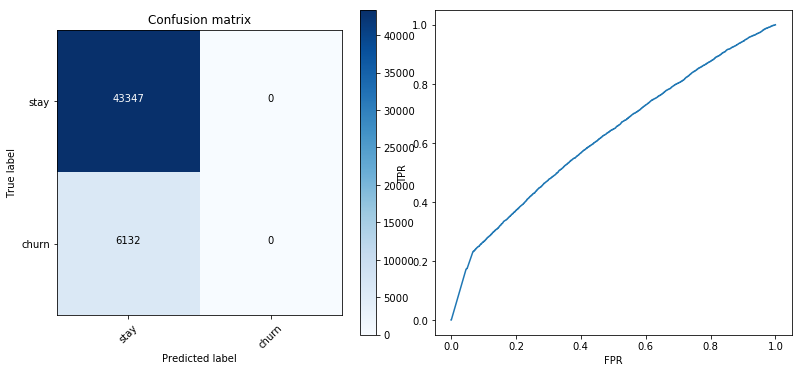

In [10]:
pm_tra_lr = PerfMatrics(y_actual=y_train,
                        X=X_train_std,
                        model=lr,
                        class_labels=class_labels)

pm_tra_lr.print_all_matrics()

Performance matrics for test data with normal LR

---------Accuracy---------
0.875978496652

---------Recall---------
0.0

---------Classification report---------
             precision    recall  f1-score   support

       stay       0.88      1.00      0.93     18576
      churn       0.00      0.00      0.00      2630

avg / total       0.77      0.88      0.82     21206


---------Confusion matrix---------
Confusion matrix, without normalization
[[18576     0]
 [ 2630     0]]

---------ROC Curve---------



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


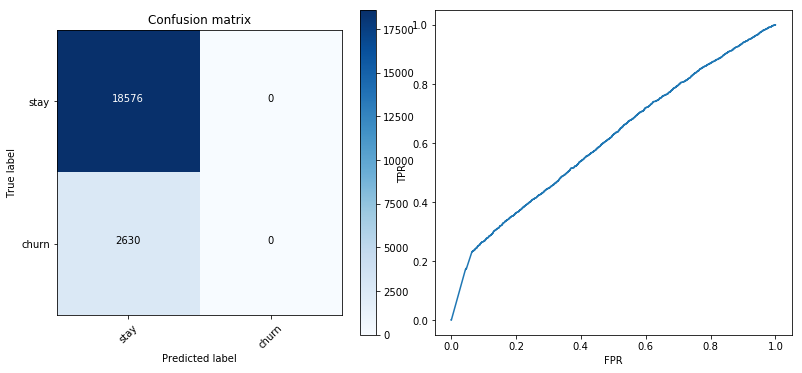

In [11]:
pm_tst_lr = PerfMatrics(y_actual=y_test,
                        X=X_test_std,
                        model=lr,
                        class_labels=class_labels)

pm_tst_lr.print_all_matrics()

Imbalanced or not?

In [12]:
print('total y balance:', sum(y) / len(y))
print('training set y balance:', sum(y_train) / len(y_train))
print('test set y balance:', sum(y_test) / len(y_test))

total y balance: 0.123958407017
training set y balance: 0.123931364821
test set y balance: 0.124021503348


In [13]:
print('LR, Training accuracy:', lr.score(X_train_std, y_train))
print('LR, Test accuracy:', lr.score(X_test_std, y_test))

LR, Training accuracy: 0.876068635179
LR, Test accuracy: 0.875978496652


###### Logistic Regression with SMOTE

In [14]:
lr_sm = LogisticRegression(penalty='l1', C=0.1)
lr_sm.fit(X_train_sm, y_train_sm)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Performance matrics for train data with LR & SMOTE

---------Accuracy---------
0.594919056569

---------Recall---------
0.567514677104

---------Classification report---------
             precision    recall  f1-score   support

       stay       0.91      0.60      0.72     43347
      churn       0.17      0.57      0.26      6132

avg / total       0.82      0.59      0.66     49479


---------Confusion matrix---------
Confusion matrix, without normalization
[[25956 17391]
 [ 2652  3480]]

---------ROC Curve---------



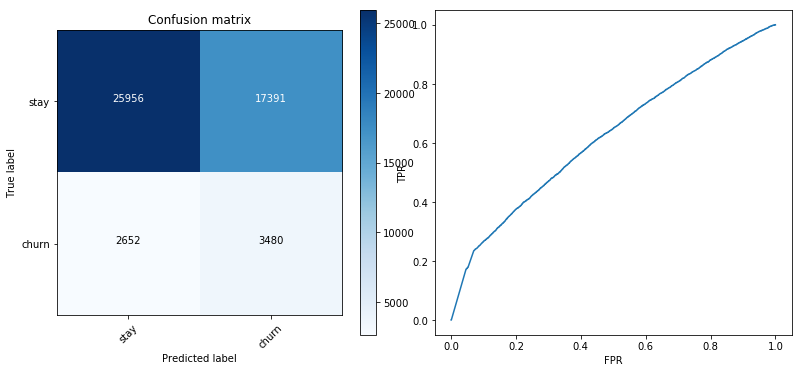

In [15]:
pm_tra_lr_sm = PerfMatrics(y_actual=y_train,
                        X=X_train_std,
                        model=lr_sm,
                        class_labels=class_labels)

pm_tra_lr_sm.print_all_matrics()

Performance matrics for test data with LR & SMOTE

---------Accuracy---------
0.591294916533

---------Recall---------
0.541825095057

---------Classification report---------
             precision    recall  f1-score   support

       stay       0.90      0.60      0.72     18576
      churn       0.16      0.54      0.25      2630

avg / total       0.81      0.59      0.66     21206


---------Confusion matrix---------
Confusion matrix, without normalization
[[11114  7462]
 [ 1205  1425]]

---------ROC Curve---------



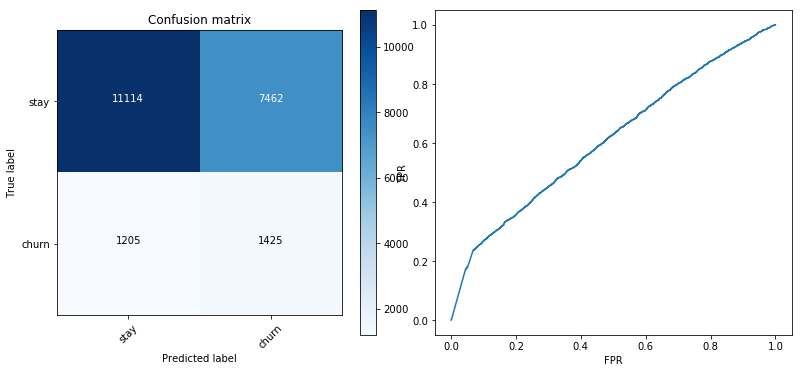

In [16]:
pm_tst_lr_sm = PerfMatrics(y_actual=y_test,
                        X=X_test_std,
                        model=lr_sm,
                        class_labels=class_labels)

pm_tst_lr_sm.print_all_matrics()

###### Random Forest

- How to rune hyper-parameters of RF model?
  - https://stackoverflow.com/questions/36107820/how-to-tune-parameters-in-random-forest-using-scikit-learn
  - https://www.fabienplisson.com/random-forest-and-grid-search/

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, random_state=12)
rf.fit(X_train_std, y_train)
print('RF, Test accuracy:', rf.score(X_test_std, y_test))
print('RF, Test recall:', recall_score(y_test, rf.predict(X_test_std)))

RF, Test accuracy: 0.865038196737
RF, Test recall: 0.015969581749


---------Accuracy---------
0.865038196737

---------Recall---------
0.015969581749

---------Classification report---------
             precision    recall  f1-score   support

       stay       0.88      0.99      0.93     18576
      churn       0.13      0.02      0.03      2630

avg / total       0.78      0.87      0.82     21206


---------Confusion matrix---------
Confusion matrix, without normalization
[[18302   274]
 [ 2588    42]]

---------ROC Curve---------



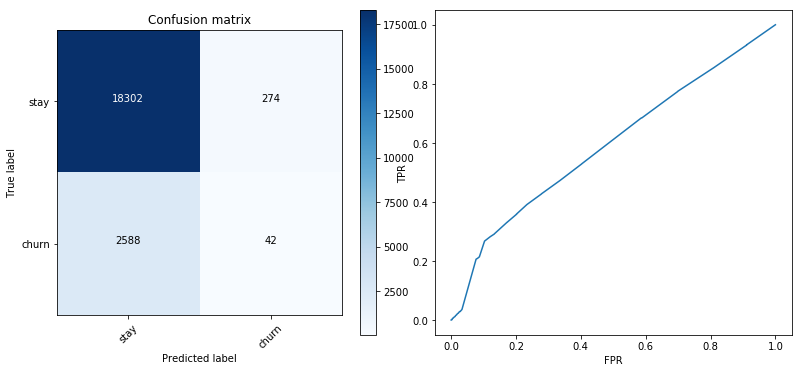

In [18]:
pm_tst_rf = PerfMatrics(y_actual=y_test,
                        X=X_test_std,
                        model=rf,
                        class_labels=class_labels)

pm_tst_rf.print_all_matrics()

###### RF with SMOTE

In [19]:
rf_sm = RandomForestClassifier(n_estimators=50, random_state=12)
rf_sm.fit(X_train_sm, y_train_sm)
print('RF, Test accuracy with SMOTE:', rf_sm.score(X_test_std, y_test))
print('RF, Test recall with SMOTE:', recall_score(y_test, rf_sm.predict(X_test_std)))

RF, Test accuracy with SMOTE: 0.815476751863
RF, Test recall with SMOTE: 0.276425855513


---------Accuracy---------
0.815476751863

---------Recall---------
0.276425855513

---------Classification report---------
             precision    recall  f1-score   support

       stay       0.90      0.89      0.89     18576
      churn       0.27      0.28      0.27      2630

avg / total       0.82      0.82      0.82     21206


---------Confusion matrix---------
Confusion matrix, without normalization
[[16566  2010]
 [ 1903   727]]

---------ROC Curve---------



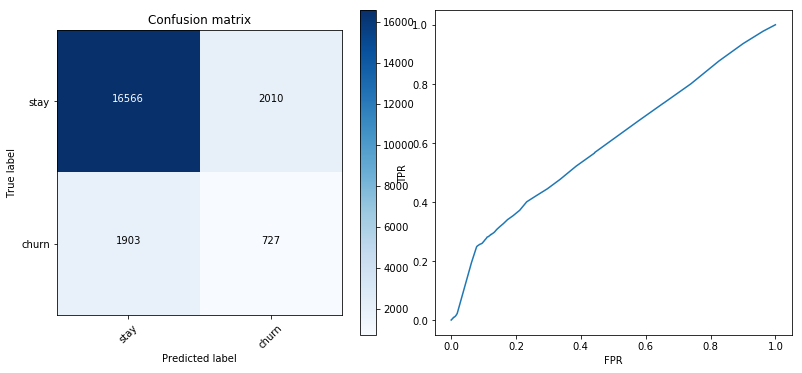

In [20]:
pm_tst_rf_sm = PerfMatrics(y_actual=y_test,
                        X=X_test_std,
                        model=rf_sm,
                        class_labels=class_labels)

pm_tst_rf_sm.print_all_matrics()

###### SVM

In [21]:
1/0

ZeroDivisionError: division by zero

In [ ]:
from sklearn import svm
help(svm.SVC)

In [ ]:
len(X_train_sm)

In [ ]:
from sklearn import svm
sv = svm.SVC(kernel='linear', C=1.0, random_state=0, cache_size=7000)
sv.fit(X_train_sm, y_train_sm)

In [ ]:
pm_tst_svm_sm = PerfMatrics(y_actual=y_test,
                        X=X_test_std,
                        model=sv_sm,
                        class_labels=class_labels)

pm_tst_svm_sm.print_all_matrics()

###### Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
tree.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

---------Accuracy---------
0.851268508913

---------Recall---------
0.223954372624

---------Classification report---------
             precision    recall  f1-score   support

       stay       0.90      0.94      0.92     18576
      churn       0.35      0.22      0.27      2630

avg / total       0.83      0.85      0.84     21206


---------Confusion matrix---------
Confusion matrix, without normalization
[[17463  1113]
 [ 2041   589]]

---------ROC Curve---------



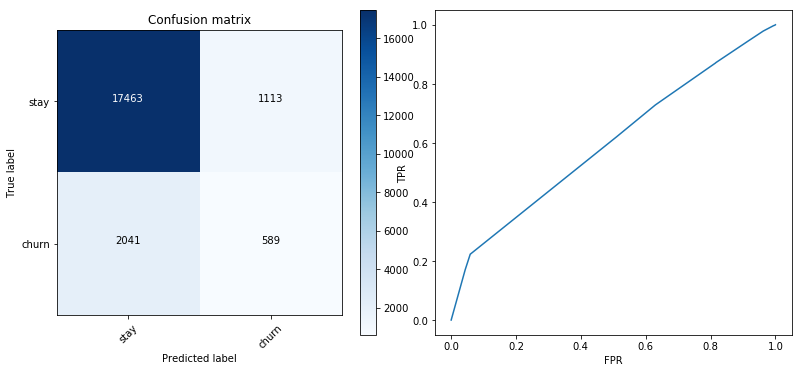

In [9]:
pm_tst_tree_sm = PerfMatrics(y_actual=y_test,
                        X=X_test_std,
                        model=tree,
                        class_labels=class_labels)

pm_tst_tree_sm.print_all_matrics()

References to use GraphVis

- https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
- https://stackoverflow.com/questions/18438997/why-is-pydot-unable-to-find-graphvizs-executables-in-windows-8

In [13]:
from sklearn.tree import export_graphviz
import pydotplus

dotfile = open("D:/dtree2.dot", 'w')
export_graphviz(tree, out_file = dotfile, feature_names=['c'+str(num) for num in range(21)])
dotfile.close()
#cmd: dot -Tpng tree.dot -o dtree2.png


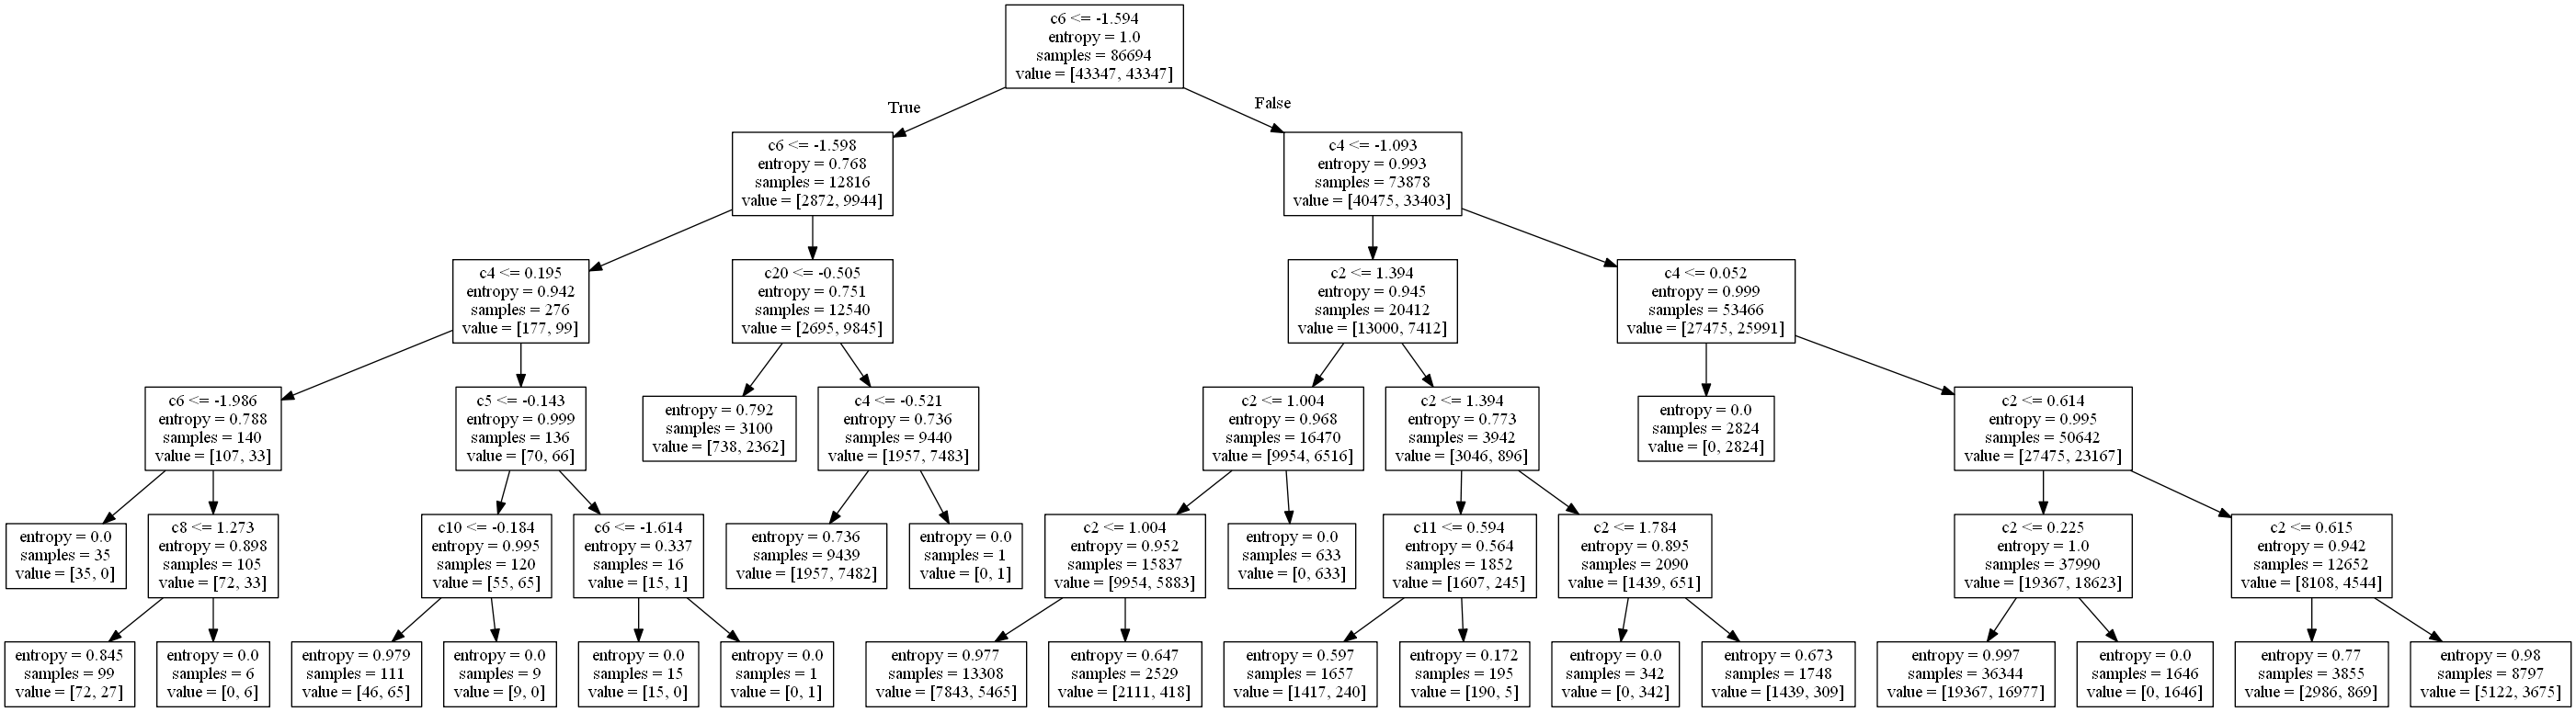

In [11]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(tree, out_file = dot_data, feature_names=['c'+str(num) for num in range(21)])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())